# Comparação entre o modelo MTL com o uso de embeddings HGI e HMMR


**Configurações usadas**

### **InputsConfig**  
- **EMBEDDING_DIM**: 64  
- **SLIDE_WINDOW**: 9  
- **PAD_VALUE**: 0  
- **TIMEOUT_TEST**: None  
- **NEXT_TARGET**: None  
- **CATEGORY_TARGET**: None  

---

### **MTLModelConfig**  
- **NUM_CLASSES**: 7  
- **BATCH_SIZE**: 2048  
- **EPOCHS**: 50  
- **LEARNING_RATE**: 0.0001  
- **K_FOLDS**: 3  

---

### **ModelParameters**  
- **INPUT_DIM**: 64
- **SHARED_LAYER_SIZE**: 256  
- **NUM_HEADS**: 8  
- **NUM_LAYERS**: 4  
- **SEQ_LENGTH**: 9  
- **NUM_SHARED_LAYERS**: 4  
- **ENCODER_OUTPUT_SIZE**: 256  
- **EXPERT_HIDDEN_SIZE**: 256  
- **EXPERT_OUTPUT_SIZE**: 256  
- **NUM_EXPERTS**: 9  


# Alabama

In [ ]:
ESTADO = "alabama"

In [1]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [ ]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

#### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi_embedding.torch'

#### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/filtrado.csv')

#### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama//embeddings.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,9531,-0.328018,-0.279717,-0.268858,-0.025124,-0.033602,0.831421,0.487451,0.345670,-0.051999,...,0.382835,0.569170,0.062280,-0.175719,0.631150,-0.055097,0.027944,0.636096,0.206160,Shopping
1,9532,-0.212724,-0.188304,-0.040483,-0.244203,1.012444,1.173037,-0.368704,-0.216277,0.044884,...,-0.090151,0.303618,0.442501,-0.290301,0.510194,-0.057238,-0.213825,0.169952,0.980230,Community
2,9533,0.957083,-0.120902,0.103594,-0.226602,0.106776,0.596069,-0.405396,0.028514,0.509419,...,-0.079732,0.831397,0.024735,-0.035905,0.493928,-0.049237,1.114538,-0.022972,0.607717,Outdoors
3,9593,-0.033946,0.299042,0.101730,-0.204093,0.044489,0.653744,0.662394,0.550874,0.672326,...,-0.085716,0.441036,0.209071,1.268344,-0.063430,-0.185252,0.540702,0.180796,-0.019045,Travel
4,9693,0.615521,-0.025080,-0.066807,-0.233809,-0.017595,0.547271,-0.263094,-0.132398,-0.088840,...,-0.188026,1.086916,-0.036607,-0.170019,0.699518,-0.245074,0.281830,-0.058471,0.175323,Entertainment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10264,7565433,-0.317049,-0.118215,-0.024992,-0.075344,-0.097142,0.470303,1.184643,-0.310203,0.385223,...,1.237868,-0.138529,1.750363,-0.187174,0.915760,-0.043957,0.691891,0.626277,0.029799,Food
10265,7568997,0.111724,-0.083904,0.190910,0.032612,-0.245301,0.713871,1.140990,-0.011070,-0.039734,...,0.244286,-0.005502,0.883621,-0.288049,0.223249,-0.191501,0.471388,-0.290527,0.050230,Shopping
10266,7570992,0.049874,-0.004915,-0.391894,0.467625,0.852172,0.454604,0.777993,0.827893,-0.138480,...,0.350916,0.725459,-0.101077,-0.175795,1.246596,0.750474,0.479635,-0.163431,-0.023801,Travel
10267,7574223,-0.295706,0.242828,-0.606082,-0.171838,1.712261,0.892785,1.275130,0.676823,1.093236,...,2.273987,-0.580897,1.323805,0.547652,2.097080,-0.205113,0.026762,-0.269167,0.473824,Food


### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 1432, Total visit sequences: 10426
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 1432/1432 [00:00<00:00, 18722.47it/s]
nextpoi_sequences shape: (10426, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 2/2 [00:07<00:00,  3.55s/it, rows_written=10426]
Finished: wrote 10426 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-23 21:03:55.217823: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761253435.237416    7045 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761253435.243346    7045 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761253435.258139    7045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761253435.258164    7045 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761253435.258169    7045 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251023_2104"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,77.41 ± 4.07,75.57 ± 1.23,76.43 ± 1.97,53766.67 ± 57.74
1,Entertainment,71.98 ± 1.99,66.21 ± 0.86,68.96 ± 0.92,19233.33 ± 57.74
2,Food,79.85 ± 0.55,77.89 ± 1.17,78.86 ± 0.80,112633.33 ± 57.74
3,Nightlife,67.37 ± 1.99,63.72 ± 4.08,65.42 ± 2.03,9366.67 ± 57.74
4,Outdoors,71.63 ± 1.75,68.24 ± 2.46,69.89 ± 2.09,16900.00 ± 0.00


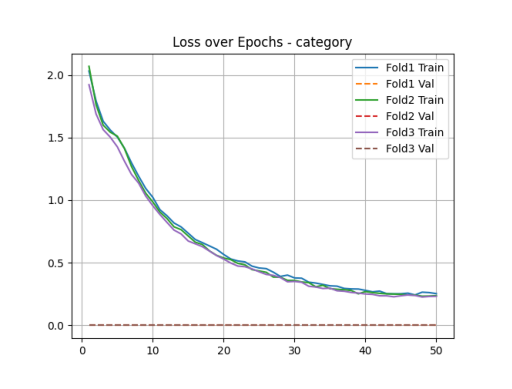

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,39.23 ± 4.29,49.51 ± 5.02,43.54 ± 2.83,68133.33 ± 57.74
1,Entertainment,15.23 ± 1.78,33.05 ± 10.23,20.33 ± 0.28,20466.67 ± 57.74
2,Food,46.46 ± 4.02,23.77 ± 7.46,30.70 ± 6.14,118366.67 ± 57.74
3,Nightlife,14.41 ± 2.77,34.31 ± 7.86,19.83 ± 1.70,13600.00 ± 0.00
4,Outdoors,13.52 ± 2.40,19.31 ± 9.39,14.92 ± 1.33,16566.67 ± 57.74


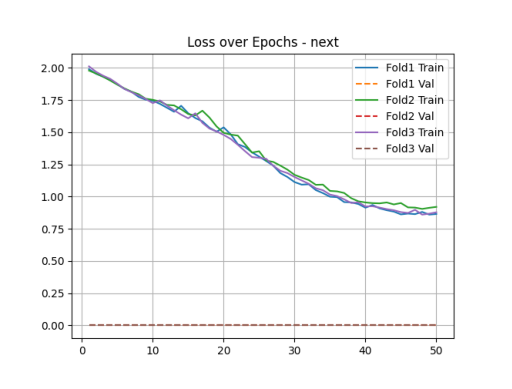

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

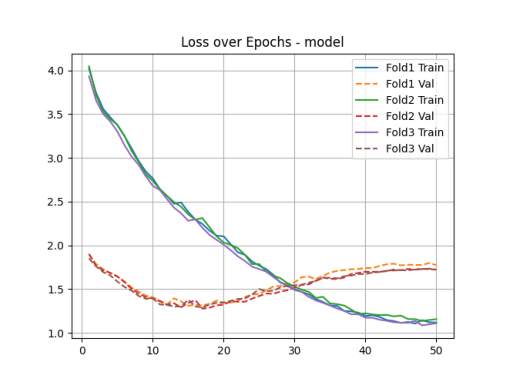

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## DGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Alabama.csv')

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Alabama.csv')

#### pois_gowalla

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"poi-encoder-gowalla-h3.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi-encoder-gowalla-h3.tensor'

In [ ]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.capitalize()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = "in_embed.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [ ]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [ ]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings.csv", index=False)


In [ ]:
out_df.head()

,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,9531,0.543268,0.327979,0.293559,-0.694416,-1.06124,0.114316,-0.119646,0.701548,-0.929829,...,0.139249,-0.198555,-0.336995,1.533049,-0.200257,-0.162336,1.11284,-0.611966,-0.167881,Shopping
1,9531,0.543268,0.327979,0.293559,-0.694416,-1.06124,0.114316,-0.119646,0.701548,-0.929829,...,0.139249,-0.198555,-0.336995,1.533049,-0.200257,-0.162336,1.11284,-0.611966,-0.167881,Shopping
2,9531,0.543268,0.327979,0.293559,-0.694416,-1.06124,0.114316,-0.119646,0.701548,-0.929829,...,0.139249,-0.198555,-0.336995,1.533049,-0.200257,-0.162336,1.11284,-0.611966,-0.167881,Shopping
3,9531,0.543268,0.327979,0.293559,-0.694416,-1.06124,0.114316,-0.119646,0.701548,-0.929829,...,0.139249,-0.198555,-0.336995,1.533049,-0.200257,-0.162336,1.11284,-0.611966,-0.167881,Shopping
4,9531,0.543268,0.327979,0.293559,-0.694416,-1.06124,0.114316,-0.119646,0.701548,-0.929829,...,0.139249,-0.198555,-0.336995,1.533049,-0.200257,-0.162336,1.11284,-0.611966,-0.167881,Shopping


### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 1432, Total visit sequences: 10426
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 1432/1432 [00:00<00:00, 19663.52it/s]
nextpoi_sequences shape: (10426, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
Resuming from row 10426 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 10426 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-24 13:46:26.912242: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 13:46:26.929355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761313586.950552    2981 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761313586.957067    2981 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761313586.973323    2981 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251024_1346"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,81366.67 ± 901.85
1,Entertainment,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,24266.67 ± 757.19
2,Food,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,139800.00 ± 781.02
3,Nightlife,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,16866.67 ± 404.15
4,Outdoors,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,19066.67 ± 1159.02


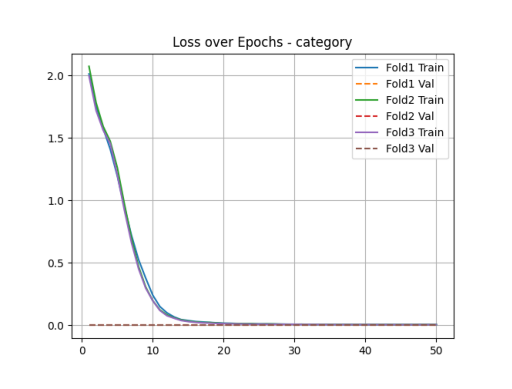

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,42.49 ± 4.68,41.98 ± 3.70,42.00 ± 1.61,68133.33 ± 57.74
1,Entertainment,15.23 ± 3.15,26.54 ± 5.76,18.80 ± 0.75,20466.67 ± 57.74
2,Food,50.07 ± 2.48,16.25 ± 3.61,24.32 ± 3.98,118366.67 ± 57.74
3,Nightlife,14.97 ± 1.14,39.22 ± 1.53,21.65 ± 1.30,13600.00 ± 0.00
4,Outdoors,11.99 ± 1.75,29.56 ± 6.87,16.76 ± 1.58,16566.67 ± 57.74


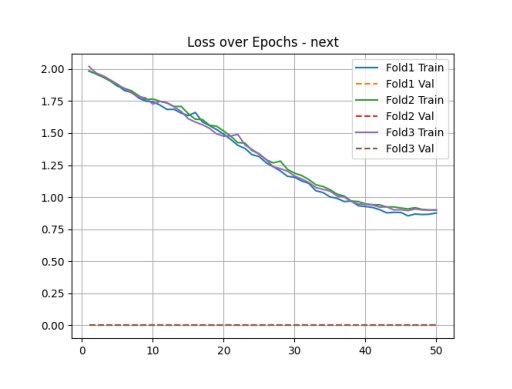

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

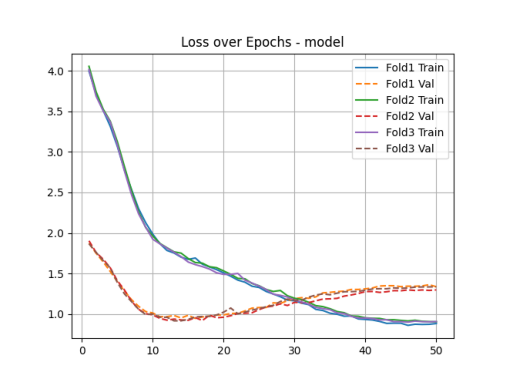

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# Florida

In [ ]:
ESTADO = "florida"

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


In [ ]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

#### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/poi_embedding.torch'

#### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/filtrado.csv')

#### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/florida//embeddings.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,9322,1.008813,-0.052989,0.641647,0.793149,-0.025132,0.031875,-0.369785,-0.003292,0.452726,...,0.183528,0.228682,0.687083,-0.105578,0.789077,1.003571,0.690377,-0.430113,0.574264,Community
1,9325,-0.132541,-0.027739,1.208324,0.252768,1.261230,-0.075908,-0.513182,-0.035265,0.534637,...,0.278563,-0.109684,0.722691,0.549364,1.654891,0.012129,0.739356,-0.474948,1.020320,Outdoors
2,9342,-0.195523,-0.229668,0.628893,-0.175455,0.781973,-0.030525,-0.191435,0.875360,0.255261,...,-0.064420,0.307125,0.029751,0.197204,0.911663,0.702920,-0.073615,-0.132970,-0.088777,Travel
3,9345,-0.039257,0.417678,0.532400,-0.098396,-0.096403,-0.133656,-0.068251,0.440455,-0.025845,...,0.749466,-0.171562,-0.000109,-0.014690,0.308836,-0.149593,1.128331,-0.421809,-0.140195,Shopping
4,9454,0.369022,-0.167540,-0.229892,0.042335,-0.117171,0.440520,0.548884,-0.211030,0.727892,...,0.630264,-0.137920,0.281128,1.411441,0.168241,-0.379470,0.277895,-0.304930,-0.167962,Shopping
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65004,7653440,0.237599,0.096230,-0.125157,-0.126481,-0.084840,-0.169926,0.027639,0.360632,0.587769,...,1.222741,-0.020495,0.401896,0.272807,0.470918,-0.142980,0.334489,-0.632842,-0.113173,Shopping
65005,7653466,1.364095,0.824177,0.399466,0.202385,-0.148990,0.934358,-0.365464,-0.315506,0.612332,...,1.124660,-0.246654,0.399501,1.434746,0.317897,-0.303680,0.963655,-0.361199,-0.142320,Nightlife
65006,7653536,0.880727,-0.598746,1.057986,-0.370144,0.001527,1.499534,-0.109344,-0.251368,-0.130891,...,-0.017682,0.631016,0.390745,0.020293,1.277066,-0.306956,0.059822,-0.804612,0.040760,Travel
65007,7678396,-0.065408,-0.042721,-0.044628,0.851581,0.513682,-0.213384,0.078865,-0.156693,0.886732,...,-0.114631,-0.331031,-0.002032,0.031227,0.127995,-0.416777,0.226492,-0.847217,-0.181256,Shopping


### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 12520, Total visit sequences: 112259
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 12520/12520 [00:00<00:00, 29870.15it/s]
nextpoi_sequences shape: (112259, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 12/12 [01:00<00:00,  5.04s/it, rows_written=112259]
Finished: wrote 112259 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-24 10:14:00.407739: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 10:14:00.425200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761300840.446941    5483 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761300840.453552    5483 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761300840.470502    5483 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251024_1014"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,74.42 ± 0.63,72.29 ± 1.26,73.34 ± 0.84,284966.67 ± 57.74
1,Entertainment,69.26 ± 3.33,67.81 ± 1.42,68.48 ± 1.45,113166.67 ± 57.74
2,Food,79.25 ± 3.62,72.98 ± 3.80,75.87 ± 0.40,662466.67 ± 57.74
3,Nightlife,64.98 ± 3.09,64.36 ± 2.42,64.59 ± 0.64,96433.33 ± 57.74
4,Outdoors,70.37 ± 2.42,68.56 ± 2.54,69.39 ± 0.12,125733.33 ± 57.74


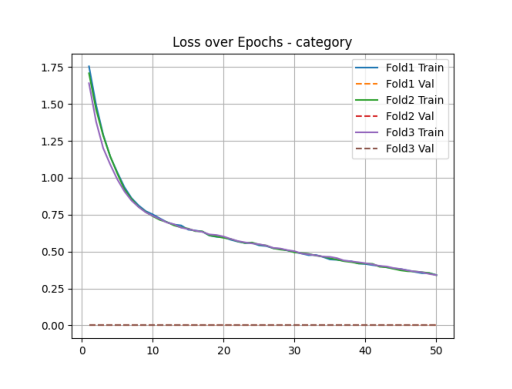

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,32.54 ± 1.68,52.93 ± 1.88,40.26 ± 0.81,293533.33 ± 4750.09
1,Entertainment,29.06 ± 2.94,38.86 ± 4.86,32.97 ± 0.17,200066.67 ± 2900.57
2,Food,44.76 ± 0.85,20.12 ± 1.55,27.73 ± 1.36,651133.33 ± 2345.92
3,Nightlife,18.90 ± 0.40,36.63 ± 1.00,24.94 ± 0.57,128900.00 ± 2080.87
4,Outdoors,19.48 ± 0.44,23.93 ± 1.96,21.46 ± 1.01,139600.00 ± 458.26


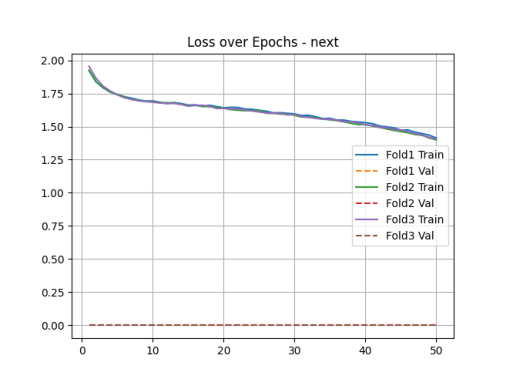

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

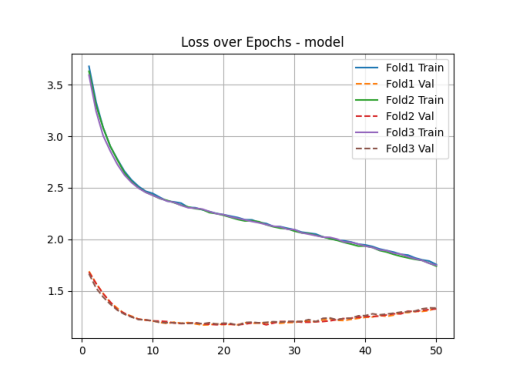

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [ ]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Florida.csv')

#### pois_gowalla

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [ ]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"poi-encoder-gowalla-h3.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/poi-encoder-gowalla-h3.tensor'

In [ ]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.capitalize()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = "in_embed.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [ ]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [ ]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings.csv", index=False)


In [ ]:
out_df.head()

,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,9322,0.745304,-0.9647,0.46538,0.241353,-0.087169,-0.764521,-0.468093,0.567993,-0.061281,...,0.4658,-0.766008,-0.173312,-0.512176,-0.478377,0.184333,-0.048606,0.823359,-0.268853,Community
1,9322,0.745304,-0.9647,0.46538,0.241353,-0.087169,-0.764521,-0.468093,0.567993,-0.061281,...,0.4658,-0.766008,-0.173312,-0.512176,-0.478377,0.184333,-0.048606,0.823359,-0.268853,Community
2,9322,0.745304,-0.9647,0.46538,0.241353,-0.087169,-0.764521,-0.468093,0.567993,-0.061281,...,0.4658,-0.766008,-0.173312,-0.512176,-0.478377,0.184333,-0.048606,0.823359,-0.268853,Community
3,9322,0.745304,-0.9647,0.46538,0.241353,-0.087169,-0.764521,-0.468093,0.567993,-0.061281,...,0.4658,-0.766008,-0.173312,-0.512176,-0.478377,0.184333,-0.048606,0.823359,-0.268853,Community
4,9322,0.745304,-0.9647,0.46538,0.241353,-0.087169,-0.764521,-0.468093,0.567993,-0.061281,...,0.4658,-0.766008,-0.173312,-0.512176,-0.478377,0.184333,-0.048606,0.823359,-0.268853,Community


### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 12520, Total visit sequences: 112259
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 12520/12520 [00:00<00:00, 21962.95it/s]
nextpoi_sequences shape: (112259, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 12/12 [01:27<00:00,  7.29s/it, rows_written=112259]
Finished: wrote 112259 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/florida/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-24 12:56:45.099190: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 12:56:45.116790: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761310605.137742    2630 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761310605.144225    2630 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761310605.160549    2630 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251024_1257"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,521400.00 ± 5864.30
1,Entertainment,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,356600.00 ± 5350.70
2,Food,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,1126400.00 ± 10016.49
3,Nightlife,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,227233.33 ± 3611.56
4,Outdoors,100.00 ± 0.00,100.00 ± 0.00,100.00 ± 0.00,244800.00 ± 7547.85


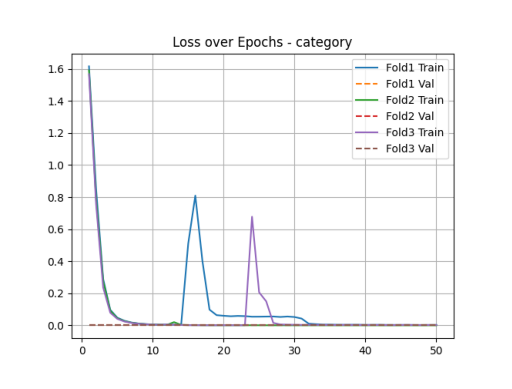

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,34.66 ± 1.81,52.64 ± 3.86,41.70 ± 0.24,484500.00 ± 0.00
1,Entertainment,31.59 ± 2.29,33.95 ± 4.21,32.52 ± 0.64,332700.00 ± 0.00
2,Food,45.85 ± 1.15,22.36 ± 4.85,29.80 ± 4.31,1076833.33 ± 57.74
3,Nightlife,20.98 ± 0.21,34.03 ± 4.38,25.90 ± 1.47,214633.33 ± 57.74
4,Outdoors,18.65 ± 0.43,29.57 ± 4.08,22.79 ± 0.90,232433.33 ± 57.74


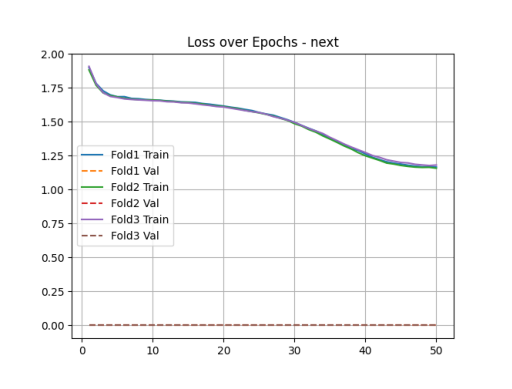

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

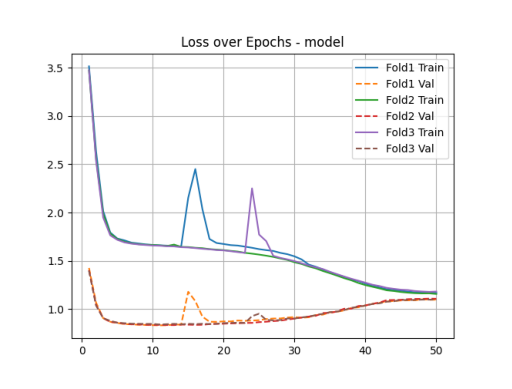

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# Montana

In [1]:
ESTADO = "montana"

In [2]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [4]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [5]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [6]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [7]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/poi_embedding.torch'

### checkins filtrados

In [8]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/filtrado.csv')

### pois_gowalla

In [9]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pois_gowalla.csv'

In [10]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/montana//embeddings.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,9890,-0.052402,-0.077046,0.167213,-0.042873,0.269487,0.226179,-0.029456,0.421556,-0.052920,...,-0.093321,0.128972,-0.049030,0.234383,0.128662,-0.039820,0.240331,0.146290,-0.039405,NaN
1,10705,0.143271,0.275168,-0.085793,0.148128,-0.022874,-0.025983,0.160545,-0.072344,0.224897,...,0.314747,0.027084,0.216773,-0.013363,-0.000748,0.044565,-0.034560,0.130725,0.132352,NaN
2,10972,0.148101,0.276470,-0.087030,0.151684,-0.022872,-0.027012,0.161541,-0.073330,0.225099,...,0.316152,0.023619,0.219703,-0.015197,-0.000838,0.045346,-0.033228,0.127447,0.135456,NaN
3,10973,0.144909,0.278048,-0.086866,0.150060,-0.022360,-0.026388,0.161462,-0.073030,0.222803,...,0.316638,0.028280,0.218725,-0.013834,0.001093,0.042401,-0.033365,0.127517,0.134507,NaN
4,10976,0.146841,0.277308,-0.086631,0.151587,-0.022704,-0.026399,0.161283,-0.073316,0.224417,...,0.316903,0.026285,0.218941,-0.014893,-0.000162,0.043607,-0.033257,0.127431,0.135203,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23546,7569655,0.222407,0.396990,-0.115048,0.218915,-0.042910,-0.045706,0.219200,-0.112721,0.318260,...,0.460505,-0.000281,0.307277,-0.031823,-0.008693,0.088339,-0.053440,0.122879,0.197050,NaN
23547,7570598,0.207886,0.373946,-0.109691,0.205791,-0.039257,-0.041917,0.207581,-0.105327,0.300943,...,0.433043,0.003474,0.290748,-0.028719,-0.007076,0.080142,-0.049517,0.123738,0.185490,NaN
23548,7571076,0.209504,0.375751,-0.110179,0.207864,-0.039764,-0.042288,0.208549,-0.106321,0.302931,...,0.435651,0.002921,0.292213,-0.029273,-0.007264,0.081081,-0.049665,0.124241,0.186561,NaN
23549,7575490,0.222273,0.397929,-0.114966,0.219263,-0.042906,-0.045419,0.219552,-0.112787,0.317656,...,0.460796,0.000763,0.307186,-0.031719,-0.008259,0.087526,-0.053379,0.122812,0.197072,NaN


### Treino com novo modelo de embeddings pelo HGI

In [14]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 37484.28it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 1/1 [00:00<00:00,  5.71it/s, rows_written=654]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [15]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-31 16:13:06.092543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761927186.124964   36934 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761927186.134938   36934 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761927186.159014   36934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761927186.159047   36934 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761927186.159053   36934 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251006_1236"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,64.08 ± 14.18,66.26 ± 8.50,64.53 ± 9.53,3266.67 ± 57.74
1,Entertainment,47.29 ± 18.12,19.37 ± 0.55,26.92 ± 3.10,2066.67 ± 57.74
2,Food,71.58 ± 3.02,76.38 ± 5.53,73.78 ± 2.55,13966.67 ± 57.74
3,Nightlife,57.85 ± 7.62,54.76 ± 5.46,55.84 ± 2.63,2800.00 ± 0.00
4,Outdoors,67.92 ± 9.16,69.19 ± 3.08,68.28 ± 4.81,3133.33 ± 57.74


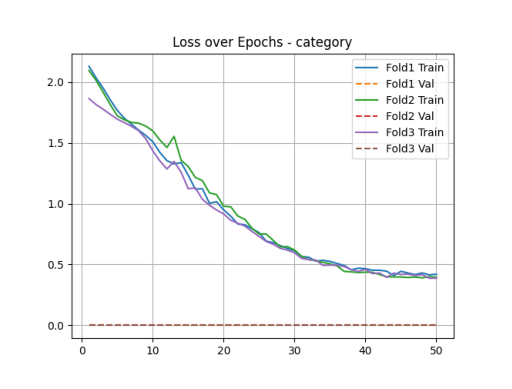

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,53.78 ± 2.75,75.65 ± 10.08,62.55 ± 2.40,4366.67 ± 57.74
1,Entertainment,18.84 ± 4.09,23.21 ± 9.28,20.62 ± 6.35,733.33 ± 57.74
2,Food,41.92 ± 8.34,12.22 ± 10.84,16.87 ± 13.45,6000.00 ± 0.00
3,Nightlife,34.44 ± 15.03,24.36 ± 8.41,26.27 ± 4.81,1233.33 ± 57.74
4,Outdoors,32.06 ± 7.78,54.03 ± 18.45,39.60 ± 9.67,1533.33 ± 57.74


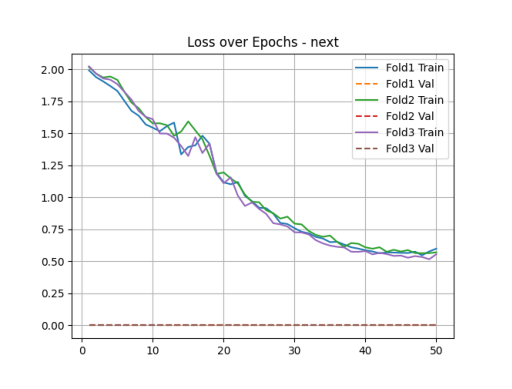

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

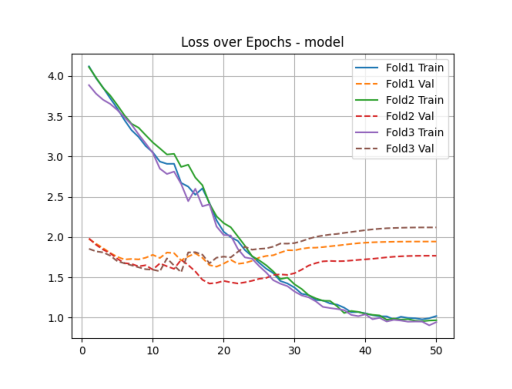

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## DGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [ ]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [16]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Montana.csv')

#### pois_gowalla

In [17]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [18]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"poi-encoder-gowalla-h3.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/poi-encoder-gowalla-h3.tensor'

In [19]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.capitalize()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = "in_embed.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [20]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [21]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings-poi-encoder.csv", index=False)


### Treino com novo modelo de embeddings pelo HGI

In [24]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 23200.51it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Resuming from row 654 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [25]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-31 16:17:06.495951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761927426.515026   38003 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761927426.520824   38003 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761927426.535274   38003 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761927426.535299   38003 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761927426.535303   38003 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251030_2316"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,3266.67 ± 57.74
1,Entertainment,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,2066.67 ± 57.74
2,Food,35.55 ± 0.68,86.87 ± 2.23,50.45 ± 0.97,13966.67 ± 57.74
3,Nightlife,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,2800.00 ± 0.00
4,Outdoors,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,3133.33 ± 57.74


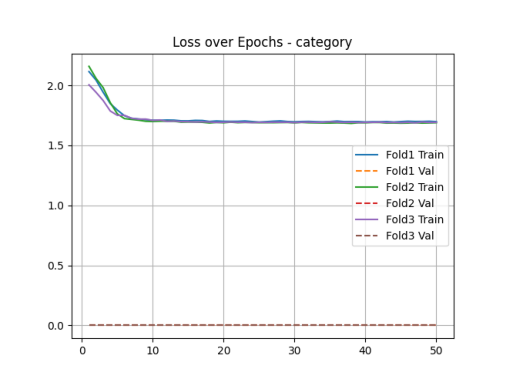

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,54.95 ± 6.44,55.62 ± 14.33,54.00 ± 4.09,4366.67 ± 57.74
1,Entertainment,8.64 ± 8.35,33.33 ± 35.95,12.48 ± 11.06,733.33 ± 57.74
2,Food,40.30 ± 8.48,25.56 ± 13.98,29.01 ± 7.44,6000.00 ± 0.00
3,Nightlife,48.75 ± 23.15,26.71 ± 11.00,31.84 ± 7.35,1233.33 ± 57.74
4,Outdoors,27.76 ± 3.19,40.83 ± 19.06,31.93 ± 5.97,1533.33 ± 57.74


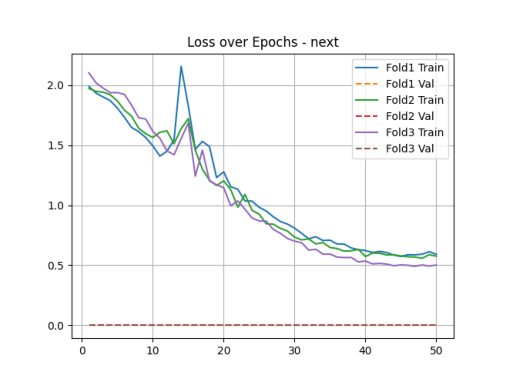

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

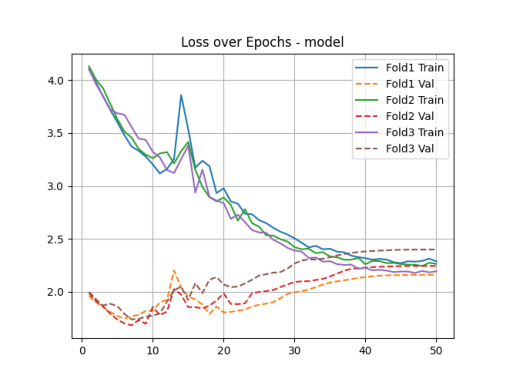

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# Nebraska

In [2]:
ESTADO = "nebraska"

In [3]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [5]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [6]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [6]:
!pip install numpy

In [7]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [8]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/poi_embedding.torch'

### checkins filtrados

In [9]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/filtrado.csv')

### pois_gowalla

In [10]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pois_gowalla.csv'

In [11]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


KeyboardInterrupt: 

### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 29576.93it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
Resuming from row 654 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-06 12:36:40.877264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759754200.924851    8364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759754200.938659    8364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759754200.975348    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975407    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975417    8364 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251006_1236"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,64.08 ± 14.18,66.26 ± 8.50,64.53 ± 9.53,3266.67 ± 57.74
1,Entertainment,47.29 ± 18.12,19.37 ± 0.55,26.92 ± 3.10,2066.67 ± 57.74
2,Food,71.58 ± 3.02,76.38 ± 5.53,73.78 ± 2.55,13966.67 ± 57.74
3,Nightlife,57.85 ± 7.62,54.76 ± 5.46,55.84 ± 2.63,2800.00 ± 0.00
4,Outdoors,67.92 ± 9.16,69.19 ± 3.08,68.28 ± 4.81,3133.33 ± 57.74


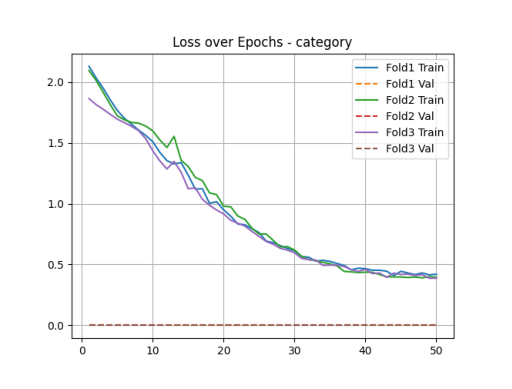

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,53.78 ± 2.75,75.65 ± 10.08,62.55 ± 2.40,4366.67 ± 57.74
1,Entertainment,18.84 ± 4.09,23.21 ± 9.28,20.62 ± 6.35,733.33 ± 57.74
2,Food,41.92 ± 8.34,12.22 ± 10.84,16.87 ± 13.45,6000.00 ± 0.00
3,Nightlife,34.44 ± 15.03,24.36 ± 8.41,26.27 ± 4.81,1233.33 ± 57.74
4,Outdoors,32.06 ± 7.78,54.03 ± 18.45,39.60 ± 9.67,1533.33 ± 57.74


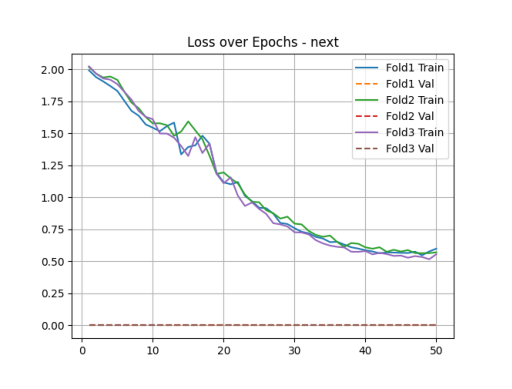

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

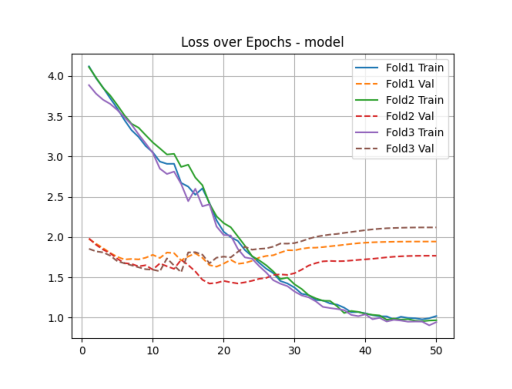

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## DGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [8]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [9]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.capitalize()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_Nebraska.csv')

#### pois_gowalla

In [10]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [11]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"poi-encoder-gowalla-h3.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/poi-encoder-gowalla-h3.tensor'

In [17]:
!pip install torch

In [23]:
!pip uninstall -y torch torchvision torchaudio
!pip install -q --extra-index-url https://download.pytorch.org/whl/cu121 \
  torch torchvision torchaudio


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.capitalize()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = "in_embed.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [13]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [14]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings-poi-encoder.csv", index=False)


### Treino com novo modelo de embeddings pelo HGI

In [19]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 421, Total visit sequences: 1899
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 421/421 [00:00<00:00, 34267.46it/s]
nextpoi_sequences shape: (1899, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 1/1 [00:01<00:00,  1.01s/it, rows_written=1899]
Finished: wrote 1899 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pre-processing/next-input.csv
Processing complete!


In [20]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-31 03:08:30.778887: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 03:08:30.796568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761880110.818348    7295 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761880110.825583    7295 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761880110.844096    7295 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [21]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251031_0308"

#### Category

In [22]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,11400.00 ± 0.00
1,Entertainment,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,6166.67 ± 57.74
2,Food,36.59 ± 0.21,97.46 ± 0.89,53.20 ± 0.34,34066.67 ± 57.74
3,Nightlife,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,7566.67 ± 57.74
4,Outdoors,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,4666.67 ± 57.74


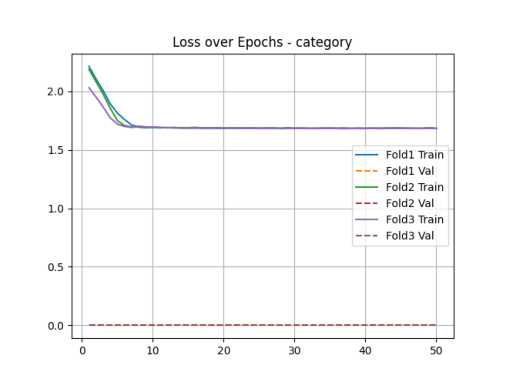

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [24]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,52.83 ± 1.88,40.22 ± 14.23,44.59 ± 9.56,10866.67 ± 57.74
1,Entertainment,22.60 ± 1.83,40.26 ± 2.94,28.87 ± 1.36,5133.33 ± 57.74
2,Food,49.50 ± 6.77,34.53 ± 7.73,40.14 ± 5.21,22966.67 ± 57.74
3,Nightlife,18.07 ± 5.83,30.26 ± 2.34,22.07 ± 3.76,3633.33 ± 57.74
4,Outdoors,13.95 ± 5.08,23.78 ± 6.92,17.48 ± 5.63,1833.33 ± 57.74


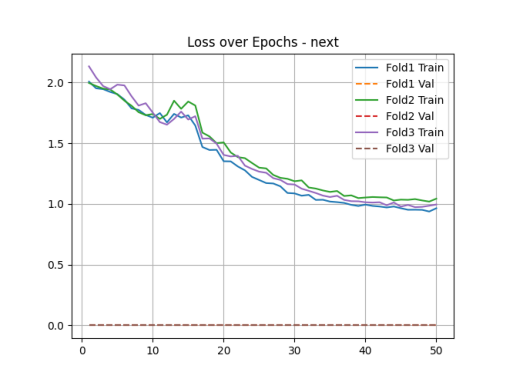

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

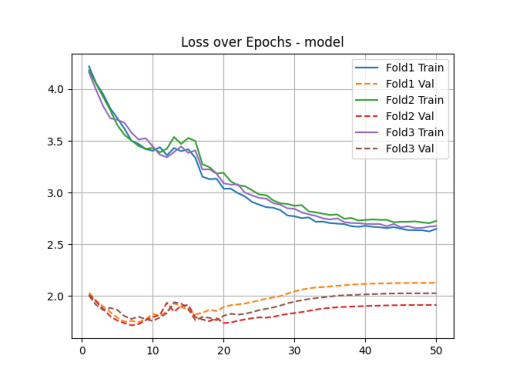

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# California

In [ ]:
ESTADO = "california"

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


## HGI

In [ ]:
import os
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)


### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [ ]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/poi_embedding.torch'

### checkins filtrados

In [ ]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.capitalize()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/filtrado.csv')

### pois_gowalla

In [ ]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/alabama/pois_gowalla.csv'

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/alabama//embeddings.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,9531,-0.328018,-0.279717,-0.268858,-0.025124,-0.033602,0.831421,0.487451,0.345670,-0.051999,...,0.382835,0.569170,0.062280,-0.175719,0.631150,-0.055097,0.027944,0.636096,0.206160,Shopping
1,9532,-0.212724,-0.188304,-0.040483,-0.244203,1.012444,1.173037,-0.368704,-0.216277,0.044884,...,-0.090151,0.303618,0.442501,-0.290301,0.510194,-0.057238,-0.213825,0.169952,0.980230,Community
2,9533,0.957083,-0.120902,0.103594,-0.226602,0.106776,0.596069,-0.405396,0.028514,0.509419,...,-0.079732,0.831397,0.024735,-0.035905,0.493928,-0.049237,1.114538,-0.022972,0.607717,Outdoors
3,9593,-0.033946,0.299042,0.101730,-0.204093,0.044489,0.653744,0.662394,0.550874,0.672326,...,-0.085716,0.441036,0.209071,1.268344,-0.063430,-0.185252,0.540702,0.180796,-0.019045,Travel
4,9693,0.615521,-0.025080,-0.066807,-0.233809,-0.017595,0.547271,-0.263094,-0.132398,-0.088840,...,-0.188026,1.086916,-0.036607,-0.170019,0.699518,-0.245074,0.281830,-0.058471,0.175323,Entertainment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10264,7565433,-0.317049,-0.118215,-0.024992,-0.075344,-0.097142,0.470303,1.184643,-0.310203,0.385223,...,1.237868,-0.138529,1.750363,-0.187174,0.915760,-0.043957,0.691891,0.626277,0.029799,Food
10265,7568997,0.111724,-0.083904,0.190910,0.032612,-0.245301,0.713871,1.140990,-0.011070,-0.039734,...,0.244286,-0.005502,0.883621,-0.288049,0.223249,-0.191501,0.471388,-0.290527,0.050230,Shopping
10266,7570992,0.049874,-0.004915,-0.391894,0.467625,0.852172,0.454604,0.777993,0.827893,-0.138480,...,0.350916,0.725459,-0.101077,-0.175795,1.246596,0.750474,0.479635,-0.163431,-0.023801,Travel
10267,7574223,-0.295706,0.242828,-0.606082,-0.171838,1.712261,0.892785,1.275130,0.676823,1.093236,...,2.273987,-0.580897,1.323805,0.547652,2.097080,-0.205113,0.026762,-0.269167,0.473824,Food


### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 29576.93it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
Resuming from row 654 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-06 12:36:40.877264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759754200.924851    8364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759754200.938659    8364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759754200.975348    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975407    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975417    8364 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251017_2100"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,53.39 ± 1.71,29.47 ± 0.57,37.97 ± 0.14,658100.00 ± 0.00
1,Entertainment,54.50 ± 7.16,25.17 ± 1.93,34.24 ± 0.79,227366.67 ± 57.74
2,Food,58.91 ± 1.23,54.35 ± 3.05,56.48 ± 1.13,1704033.33 ± 57.74
3,Nightlife,61.77 ± 4.38,33.87 ± 0.47,43.73 ± 1.44,168666.67 ± 57.74
4,Outdoors,55.49 ± 2.66,24.75 ± 0.76,34.21 ± 0.37,320100.00 ± 0.00


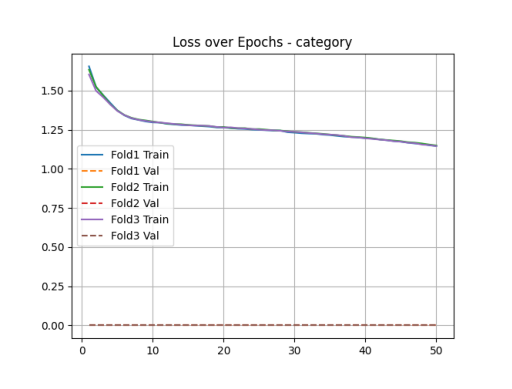

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,33.14 ± 1.26,34.29 ± 2.87,33.62 ± 0.71,729366.67 ± 611.01
1,Entertainment,18.31 ± 1.07,24.17 ± 2.50,20.80 ± 1.27,343500.00 ± 984.89
2,Food,47.83 ± 0.81,21.54 ± 2.56,29.62 ± 2.23,1727600.00 ± 15062.20
3,Nightlife,15.17 ± 0.54,38.69 ± 1.77,21.77 ± 0.28,267033.33 ± 2285.46
4,Outdoors,18.69 ± 2.30,31.71 ± 4.49,23.32 ± 1.29,382000.00 ± 1646.21


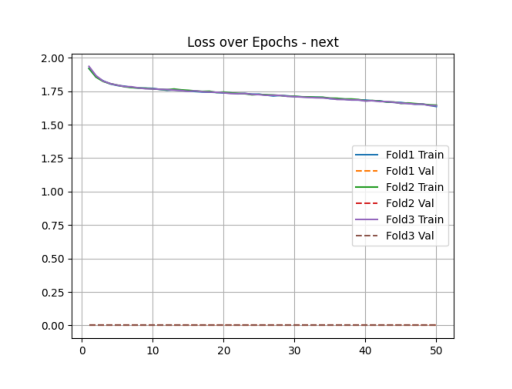

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

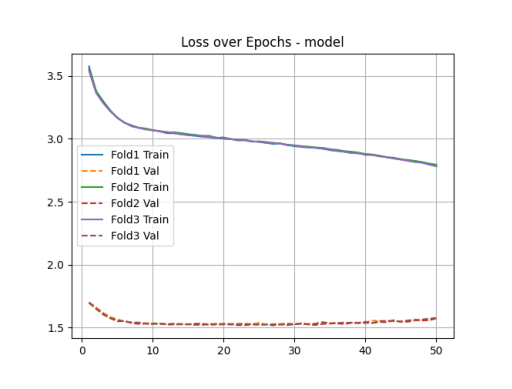

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# North Carolina

In [24]:
ESTADO = "North Carolina"

In [2]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [25]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"
diretorio_region_embedding = "/content/drive/MyDrive/region-embedding-benchmark-main/region-embedding-benchmark-main"
diretorio_hgi = f"{diretorio_region_embedding}/region-embedding/baselines/HGI"


In [4]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [26]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [6]:
!pip install numpy

In [27]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


## HGI

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

### poi_embedding.torch

In [28]:
import shutil
arquivo_origem = os.path.join(diretorio_hgi, "data", "poi_embedding.torch")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi_embedding.torch")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/poi_embedding.torch'

### checkins filtrados

In [29]:
from pathlib import Path


src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_North Carolina.csv"


output_state_dir = Path(diretorio_principal) / "data" / "output" / ESTADO
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"filtrado.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/filtrado.csv')

### pois_gowalla

In [30]:
arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/pois_gowalla.csv'

In [31]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


Arquivo salvo em: /content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina//embeddings.csv


,placeid,0,1,2,3,4,5,6,7,8,...,55,56,57,58,59,60,61,62,63,category
0,9890,-0.052402,-0.077046,0.167213,-0.042873,0.269487,0.226179,-0.029456,0.421556,-0.052920,...,-0.093321,0.128972,-0.049030,0.234383,0.128662,-0.039820,0.240331,0.146290,-0.039405,Entertainment
1,10705,0.143271,0.275168,-0.085793,0.148128,-0.022874,-0.025983,0.160545,-0.072344,0.224897,...,0.314747,0.027084,0.216773,-0.013363,-0.000748,0.044565,-0.034560,0.130725,0.132352,Entertainment
2,10972,0.148101,0.276470,-0.087030,0.151684,-0.022872,-0.027012,0.161541,-0.073330,0.225099,...,0.316152,0.023619,0.219703,-0.015197,-0.000838,0.045346,-0.033228,0.127447,0.135456,Entertainment
3,10973,0.144909,0.278048,-0.086866,0.150060,-0.022360,-0.026388,0.161462,-0.073030,0.222803,...,0.316638,0.028280,0.218725,-0.013834,0.001093,0.042401,-0.033365,0.127517,0.134507,Outdoors
4,10976,0.146841,0.277308,-0.086631,0.151587,-0.022704,-0.026399,0.161283,-0.073316,0.224417,...,0.316903,0.026285,0.218941,-0.014893,-0.000162,0.043607,-0.033257,0.127431,0.135203,Outdoors
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23546,7569655,0.222407,0.396990,-0.115048,0.218915,-0.042910,-0.045706,0.219200,-0.112721,0.318260,...,0.460505,-0.000281,0.307277,-0.031823,-0.008693,0.088339,-0.053440,0.122879,0.197050,Community
23547,7570598,0.207886,0.373946,-0.109691,0.205791,-0.039257,-0.041917,0.207581,-0.105327,0.300943,...,0.433043,0.003474,0.290748,-0.028719,-0.007076,0.080142,-0.049517,0.123738,0.185490,Nightlife
23548,7571076,0.209504,0.375751,-0.110179,0.207864,-0.039764,-0.042288,0.208549,-0.106321,0.302931,...,0.435651,0.002921,0.292213,-0.029273,-0.007264,0.081081,-0.049665,0.124241,0.186561,Community
23549,7575490,0.222273,0.397929,-0.114966,0.219263,-0.042906,-0.045419,0.219552,-0.112787,0.317656,...,0.460796,0.000763,0.307186,-0.031719,-0.008259,0.087526,-0.053379,0.122812,0.197072,Outdoors


### Treino com novo modelo de embeddings pelo HGI

In [32]:
state = ESTADO
!python -m pipelines.create_inputs "{state}"

Generating sequences for each user...
Users with valid sequences: 3311, Total visit sequences: 25572
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 3311/3311 [00:00<00:00, 30833.14it/s]
nextpoi_sequences shape: (25572, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 3/3 [00:14<00:00,  4.88s/it, rows_written=25572]
Finished: wrote 25572 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/pre-processing/next-input.csv
Processing complete!


In [34]:
state = ESTADO

!python -m pipelines.mtlnet_trainer "{state}"

2025-10-31 15:26:06.029933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761924366.049515   24678 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761924366.055354   24678 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761924366.070093   24678 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761924366.070117   24678 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1761924366.070121   24678 computation_placer.cc:177] computation placer alr

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251006_1236"

### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,64.08 ± 14.18,66.26 ± 8.50,64.53 ± 9.53,3266.67 ± 57.74
1,Entertainment,47.29 ± 18.12,19.37 ± 0.55,26.92 ± 3.10,2066.67 ± 57.74
2,Food,71.58 ± 3.02,76.38 ± 5.53,73.78 ± 2.55,13966.67 ± 57.74
3,Nightlife,57.85 ± 7.62,54.76 ± 5.46,55.84 ± 2.63,2800.00 ± 0.00
4,Outdoors,67.92 ± 9.16,69.19 ± 3.08,68.28 ± 4.81,3133.33 ± 57.74


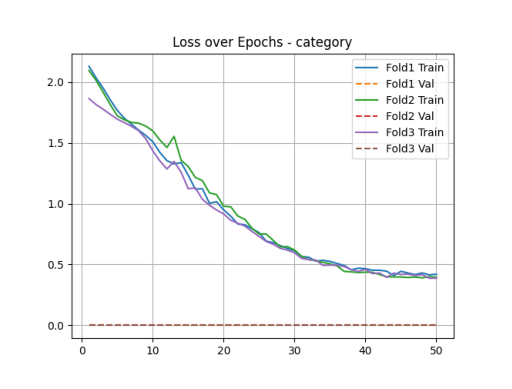

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,53.78 ± 2.75,75.65 ± 10.08,62.55 ± 2.40,4366.67 ± 57.74
1,Entertainment,18.84 ± 4.09,23.21 ± 9.28,20.62 ± 6.35,733.33 ± 57.74
2,Food,41.92 ± 8.34,12.22 ± 10.84,16.87 ± 13.45,6000.00 ± 0.00
3,Nightlife,34.44 ± 15.03,24.36 ± 8.41,26.27 ± 4.81,1233.33 ± 57.74
4,Outdoors,32.06 ± 7.78,54.03 ± 18.45,39.60 ± 9.67,1533.33 ± 57.74


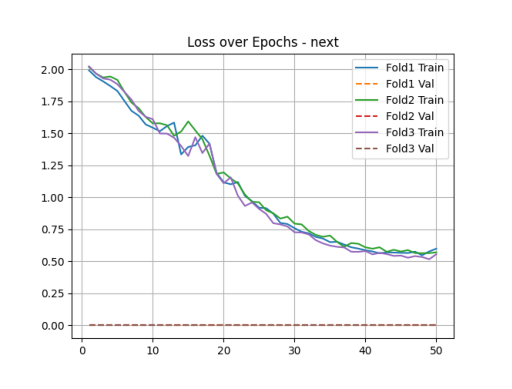

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

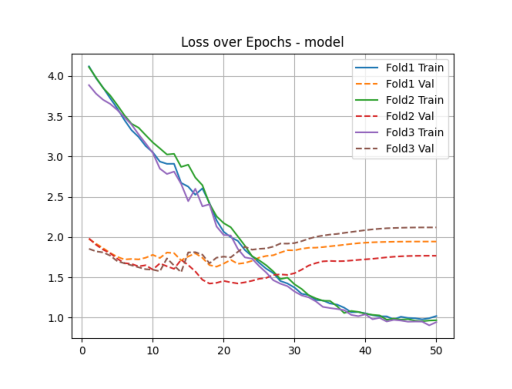

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

## DGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

## POI Embedding

### Primeiro, esses códigos irão passar automaticamente os arquivos do region-embedding para o diretório MTLPoi atual

In [22]:
diretorio_principal

'/content/drive/MyDrive/MTL_POI_Novo'

#### checkins filtrados

In [26]:
from pathlib import Path
import shutil

src_dir = Path(diretorio_region_embedding) / "estados" / "crus"
arquivo_origem = src_dir / f"checkins_{ESTADO.title()}.csv"


output_state_dir = Path(diretorio_principal) / "data" / "checkins"
output_state_dir.mkdir(parents=True, exist_ok=True)

arquivo_destino = output_state_dir / f"checkins_{ESTADO.title()}.csv"
shutil.copy2(arquivo_origem, arquivo_destino)


PosixPath('/content/drive/MyDrive/MTL_POI_Novo/data/checkins/checkins_North Carolina.csv')

#### pois_gowalla

In [27]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"pois_gowalla.csv")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "pois_gowalla.csv")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/pois_gowalla.csv'

#### poi-encoder-gowalla-h3.tensor

In [28]:
import os

arquivo_origem = os.path.join(diretorio_region_embedding,"poi-encoder-gowalla-h3.tensor")
output_state_dir = f"{diretorio_principal}/data/output/{ESTADO}"
os.makedirs(output_state_dir, exist_ok=True)
arquivo_destino = os.path.join(output_state_dir, "poi-encoder-gowalla-h3.tensor")
shutil.copy(arquivo_origem, arquivo_destino)


'/content/drive/MyDrive/MTL_POI_Novo/data/output/North Carolina/poi-encoder-gowalla-h3.tensor'

In [ ]:
!pip install torch

In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install -q --extra-index-url https://download.pytorch.org/whl/cu121 \
  torch torchvision torchaudio


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [31]:
import sys
import numpy as np
import pandas as pd
import torch

pois_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/pois_gowalla.csv")
tensor_path = Path(f"{diretorio_principal}/data/output/{ESTADO}/poi-encoder-gowalla-h3.tensor")
filtrado_path = Path(f"{diretorio_principal}/data/checkins/checkins_{ESTADO.title()}.csv")

def load_embedding_matrix(tensor_path: str, key: str = "in_embed.weight") -> np.ndarray:
    """
    Carrega o .tensor (checkpoint PyTorch) e retorna um numpy array (num_fclass, emb_dim).
    """
    ckpt = torch.load(tensor_path, map_location="cpu")
    if key not in ckpt:
        raise KeyError(f"Chave '{key}' não encontrada no arquivo '{tensor_path}'. "
                       f"Chaves disponíveis: {list(ckpt.keys())[:10]}...")
    W = ckpt[key]
    if not isinstance(W, torch.Tensor):
        raise TypeError(f"Valor em '{key}' não é um torch.Tensor (veio {type(W)}).")
    if W.ndim != 2:
        raise ValueError(f"Esperado tensor 2D em '{key}', mas veio shape {tuple(W.shape)}.")
    return W.detach().cpu().numpy()


def build_output_df(pois_path: str, W: np.ndarray, filtrado_path: str) -> pd.DataFrame:
    """
    Gera o DataFrame final com:
      - placeid (copiado de feature_id)
      - emb_0 ... emb_(D-1) mapeados por fclass
      - category (join com filtrado.csv via placeid)
    """
    pois = pd.read_csv(pois_path)
    if "feature_id" not in pois.columns or "fclass" not in pois.columns:
        raise KeyError("O arquivo pois_gowalla.csv deve conter as colunas 'feature_id' e 'fclass'. "
                       f"Colunas encontradas: {list(pois.columns)}")

    pois["feature_id"] = pois["feature_id"].astype(str)
    try:
        pois["fclass"] = pois["fclass"].astype(int)
    except Exception as e:
        raise ValueError("Falha ao converter 'fclass' para int. "
                         "Verifique se há valores não numéricos.") from e

    num_classes, emb_dim = W.shape

    n = len(pois)
    emb = np.full((n, emb_dim), np.nan, dtype=float)

    valid = (pois["fclass"] >= 0) & (pois["fclass"] < num_classes)
    if not valid.all():
        invalid_rows = (~valid).sum()

    emb[valid.values] = W[pois.loc[valid, "fclass"].to_numpy()]

    emb_cols = [f"{i}" for i in range(emb_dim)]
    out = pd.DataFrame(emb, columns=emb_cols)
    out.insert(0, "placeid", pois["feature_id"].astype(str))

    filtrado = pd.read_csv(filtrado_path)

    if "placeid" not in filtrado.columns:
        if "feature_id" in filtrado.columns:
            filtrado = filtrado.rename(columns={"feature_id": "placeid"})
        else:
            raise KeyError("O arquivo filtrado.csv deve conter a coluna 'placeid'. "
                           f"Colunas encontradas: {list(filtrado.columns)}")

    if "category" not in filtrado.columns:
        raise KeyError("O arquivo filtrado.csv deve conter a coluna 'category'.")

    filtrado["placeid"] = filtrado["placeid"].astype(str)

    out = out.merge(filtrado[["placeid", "category"]], on="placeid", how="left")



    return out



In [32]:
W =load_embedding_matrix(tensor_path)
out_df = build_output_df(pois_path, W, filtrado_path)


In [33]:
pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
out_df.to_csv(f"{pasta_output}/embeddings-poi-encoder.csv", index=False)


### Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 421, Total visit sequences: 1899
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 421/421 [00:00<00:00, 34267.46it/s]
nextpoi_sequences shape: (1899, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pre-processing/poi-sequences.csv

Generating next POI input data...
/content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pre-processing/next-input.csv
No existing file found; starting from scratch.
Batches: 100% 1/1 [00:01<00:00,  1.01s/it, rows_written=1899]
Finished: wrote 1899 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/nebraska/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-31 03:08:30.778887: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 03:08:30.796568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761880110.818348    7295 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761880110.825583    7295 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1761880110.844096    7295 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Sumário do Treino

In [ ]:
pasta_results = f"{diretorio_principal}/results/{ESTADO}/mtlnet_lr1.0e-04_bs2048_ep50_20251031_0308"

#### Category

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,11400.00 ± 0.00
1,Entertainment,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,6166.67 ± 57.74
2,Food,36.59 ± 0.21,97.46 ± 0.89,53.20 ± 0.34,34066.67 ± 57.74
3,Nightlife,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,7566.67 ± 57.74
4,Outdoors,0.00 ± 0.00,0.00 ± 0.00,0.00 ± 0.00,4666.67 ± 57.74


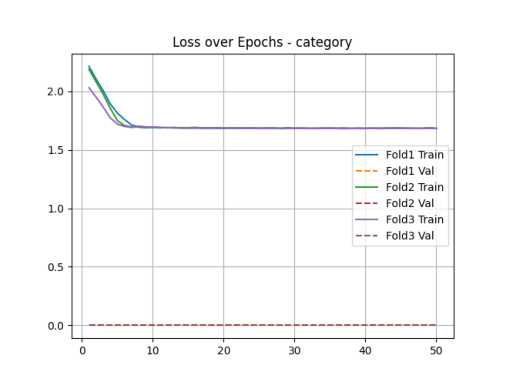

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Next

In [ ]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,52.83 ± 1.88,40.22 ± 14.23,44.59 ± 9.56,10866.67 ± 57.74
1,Entertainment,22.60 ± 1.83,40.26 ± 2.94,28.87 ± 1.36,5133.33 ± 57.74
2,Food,49.50 ± 6.77,34.53 ± 7.73,40.14 ± 5.21,22966.67 ± 57.74
3,Nightlife,18.07 ± 5.83,30.26 ± 2.34,22.07 ± 3.76,3633.33 ± 57.74
4,Outdoors,13.95 ± 5.08,23.78 ± 6.92,17.48 ± 5.63,1833.33 ± 57.74


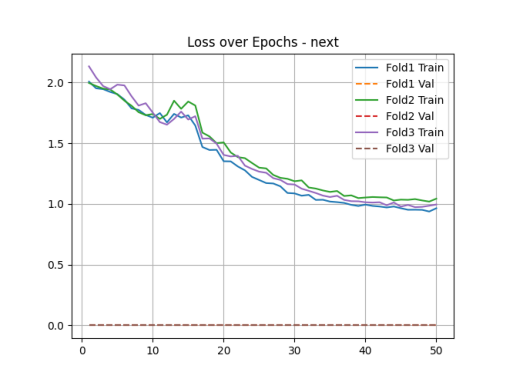

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

#### Geral (Model)

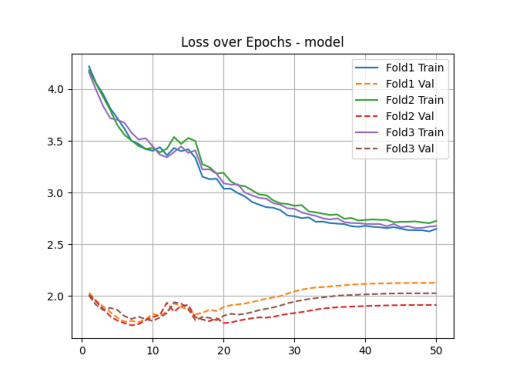

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()